<a href="https://colab.research.google.com/github/veiro/tesis-imputacion-datos/blob/main/codigo/metricas/rmse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Similiridad semantica, similutd del coseno
- el objetivo es ver que tan similares son semanticamente las tuplas utilizadas en la tarea de prediccion


# Configuracion

In [ ]:
USAR_GOOGLE_DRIVE =  True
MODO_DESARROLLO = False



In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity


#Descarga de datos y preprocesamiento





In [ ]:
%%time
if (USAR_GOOGLE_DRIVE):
  drive.mount('/content/gdrive')
  PATH_DATA_PROCESADA = "/content/gdrive/MyDrive/Maestria/Tesis/Codigo/data/data-procesada"
  sys.path.append('/content/gdrive/MyDrive/Maestria/Tesis/Codigo/utils')

else:
  PATH_DATA_PROCESADA = "/mnt"


import utils as utils
import importlib
importlib.reload(utils)

if (30 ==  utils.version()):
  print("version correcta")
else:
  raise Exception("Version de Util vieja")



Mounted at /content/gdrive
version correcta
CPU times: user 3.23 s, sys: 422 ms, total: 3.65 s
Wall time: 17.6 s


# Utils

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def prettyPrintName(strat):
  if('Transformer' in  strat):
    return 'Transformer'
  elif('XGBoost' in  strat):
    return 'XGBoost'
  elif('Knn' in  strat):
    return 'Knn'
  elif('GAIN' in  strat):
    return 'GAIN'
  elif('MIDA' in  strat):
    return 'MIDASpy'
  elif('constant' in  strat):
    return 'constant'
  elif('most_frequent' in  strat):
    return 'most_frequent'
  elif('mean' in  strat):
    return 'mean'
  elif('median' in  strat):
    return 'median'
  elif('IterativeImputer' in  strat):
    return 'IterativeImputer'
  else:
    return strat


def guardoResultados(strat, rmse):
  global df_resultados

  print("Strategy: " + prettyPrintName(strat) + ' - rmse: ' + str(rmse) )
  df_resultados = pd.concat([df_resultados , pd.DataFrame([{ 'Strategy':prettyPrintName(strat),'rmse':rmse}])])


def calcularMetricas(data, imputed_data, strat, mask_test_open):
  rmse = utils.rmse(data.to_numpy(), imputed_data.to_numpy(), mask_test_open)
  print("rmse :", rmse)
  guardoResultados(strat, rmse)


# calcular similtudes coseno con la codificacion de pycaret para prediccion numerico



In [ ]:
df_train_encoded, df_train_encoded_missing, mask_train_open = utils.obtenerDatosTrain(MODO_DESARROLLO, PATH_DATA_PROCESADA)

df_test_encoded, df_test_encoded_missing, mask_test_open = utils.obtenerDatosTest(MODO_DESARROLLO, PATH_DATA_PROCESADA)
df_test_encoded = pd.DataFrame(df_test_encoded, columns = df_train_encoded.columns).reset_index(drop=True)



In [ ]:
# el tema es que el encoding ya guardaba cosas, entocnes me traje el codigo y lo modifique para codificar nomas.
def encoding(dataset, PATH_DATA_PROCESADA):
  global encoderOHE
  global encoderLE1
  global encoderLE2
  global encoderLE3
  global encoded_df_Country_Region_cols

  # ENCODING
  # 1- onehotenconding de Country_Region
  df=dataset

  encoded_data = encoderOHE.fit_transform( df[['Country_Region']])
  encoded_df_Country_Region = pd.DataFrame(encoded_data, columns=encoderOHE.get_feature_names_out(['Country_Region']))
  encoded_df_Country_Region_cols = encoded_df_Country_Region.shape[1]

  df = df.drop(['Country_Region'], axis=1)

  # hice este concat horrible por que por alguna razon no me andaba bien el concant ordinario
  pos = encoded_df_Country_Region_cols
  for col in df.columns:
    encoded_df_Country_Region.insert( pos, col, df[col].to_numpy(), True)
    pos=pos+1

  df = encoded_df_Country_Region

  # 2 Province_State, Last_Update, date
  df['Province_State_encoded'] = encoderLE1.fit_transform(df['Province_State'])
  df = df.drop(['Province_State'], axis=1)

  df['Last_Update_encoded'] = encoderLE2.fit_transform(df['Last_Update'])
  df = df.drop(['Last_Update'], axis=1)

  df['date_encoded'] = encoderLE3.fit_transform(df['date'])
  df = df.drop(['date'], axis=1)

  df.reset_index(drop=True)

  # guardo los modelos utilizados:
  #save_pickle_model('encoderOHE',encoderOHE, PATH_DATA_PROCESADA )
  #save_pickle_model('encoderLE1',encoderLE1, PATH_DATA_PROCESADA)
  #save_pickle_model('encoderLE2',encoderLE1, PATH_DATA_PROCESADA)
  #save_pickle_model('encoderLE3',encoderLE1, PATH_DATA_PROCESADA)
  #save_pickle_model('encoded_df_Country_Region_cols',encoderLE1, PATH_DATA_PROCESADA)
  return df

import pickle
def save_pickle_model(name, model, PATH_DATA_PROCESADA):
 with open(PATH_DATA_PROCESADA + '/' + name , 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle_model(name, PATH_DATA_PROCESADA):
  with open(PATH_DATA_PROCESADA + '/' + name, 'rb') as handle:
      model = pickle.load(handle)
  return model
  # variables gloables
encoded_df_Country_Region_cols = 0
encoderOHE = OneHotEncoder(handle_unknown='ignore')
encoderLE1 = LabelEncoder()
encoderLE2 = LabelEncoder()
encoderLE3 = LabelEncoder()



encoderOHE = load_pickle_model('encoderOHE', PATH_DATA_PROCESADA)
encoderLE1 = load_pickle_model('encoderLE1', PATH_DATA_PROCESADA)
encoderLE2 = load_pickle_model('encoderLE2', PATH_DATA_PROCESADA)
encoderLE3 = load_pickle_model('encoderLE3', PATH_DATA_PROCESADA)
encoded_df_Country_Region_cols = load_pickle_model('encoded_df_Country_Region_cols', PATH_DATA_PROCESADA)

In [ ]:
df_resultados = pd.DataFrame(columns=['Strategy', 'rmse' ])
files=[
       'csse_covid_19_data_strategy=constant_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_strategy=most_frequent_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_strategy=mean_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_strategy=median_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_strategy=IterativeImputer_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_MIDASpy_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_GAIN._Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_Transformer_final_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_XGBoost_full_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_Knn_full_Desarrollo='+str(MODO_DESARROLLO)+'.csv']

#files=['csse_covid_19_data_MIDA_Desarrollo='+str(MODO_DESARROLLO)+'.csv',]
for fp in  files:
  print("Inicio " + fp)
  data_imputed_full = pd.read_csv(PATH_DATA_PROCESADA+'/'+fp)
  if(MODO_DESARROLLO):
    data_imputed =  data_imputed_full.sample(n=10000, random_state=1,replace=True ).reset_index(drop=True)
  else:
    data_imputed = data_imputed_full.reset_index(drop=True)
  #print(data_imputed['Country_Region'].value_counts())
  data_imputed_encoded =  encoding(data_imputed, PATH_DATA_PROCESADA).reset_index(drop=True)
  calcularMetricas(df_test_encoded, data_imputed_encoded, fp, mask_test_open)

  del data_imputed_encoded
  del data_imputed_full
  del data_imputed

  print("Fin  " + fp)
  print("-----------------------------------")

Inicio csse_covid_19_data_strategy=constant_Desarrollo=False.csv
rmse : 28781.212087040436
Strategy: constant - rmse: 28781.212087040436
Fin  csse_covid_19_data_strategy=constant_Desarrollo=False.csv
-----------------------------------
Inicio csse_covid_19_data_strategy=most_frequent_Desarrollo=False.csv
rmse : 28781.211395445887
Strategy: most_frequent - rmse: 28781.211395445887
Fin  csse_covid_19_data_strategy=most_frequent_Desarrollo=False.csv
-----------------------------------
Inicio csse_covid_19_data_strategy=mean_Desarrollo=False.csv
rmse : 28318.154102262633
Strategy: mean - rmse: 28318.154102262633
Fin  csse_covid_19_data_strategy=mean_Desarrollo=False.csv
-----------------------------------
Inicio csse_covid_19_data_strategy=median_Desarrollo=False.csv
rmse : 28673.478681392808
Strategy: median - rmse: 28673.478681392808
Fin  csse_covid_19_data_strategy=median_Desarrollo=False.csv
-----------------------------------
Inicio csse_covid_19_data_strategy=IterativeImputer_Desarro

## Resultados

In [ ]:
df_resultados


,Strategy,rmse
0,constant,28781.212087
0,most_frequent,28781.211395
0,mean,28318.154102
0,median,28673.478681
0,IterativeImputer,19036.535186
0,MIDASpy,23420.206728
0,GAIN,24601.053898
0,Transformer,15137.245836
0,XGBoost,15544.731617
0,Knn,14276.790654


## Plot de resultados

<Axes: xlabel='Strategy'>

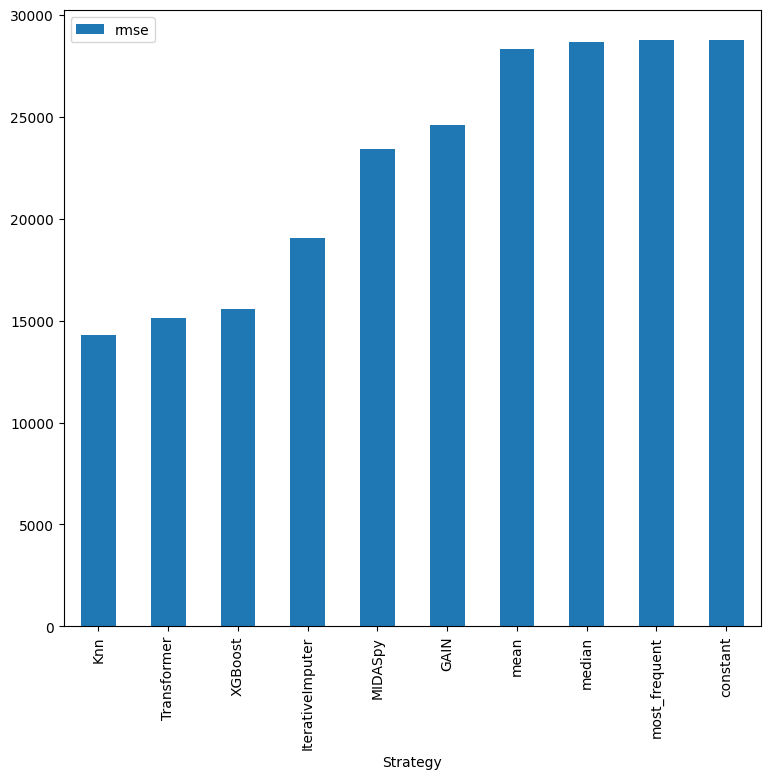

In [ ]:
df_resultados.sort_values(by=['rmse'], ascending=True).plot(x='Strategy', y=["rmse"], kind="bar", figsize=(9, 8))